LJP 3d, density 0.8, with pbc

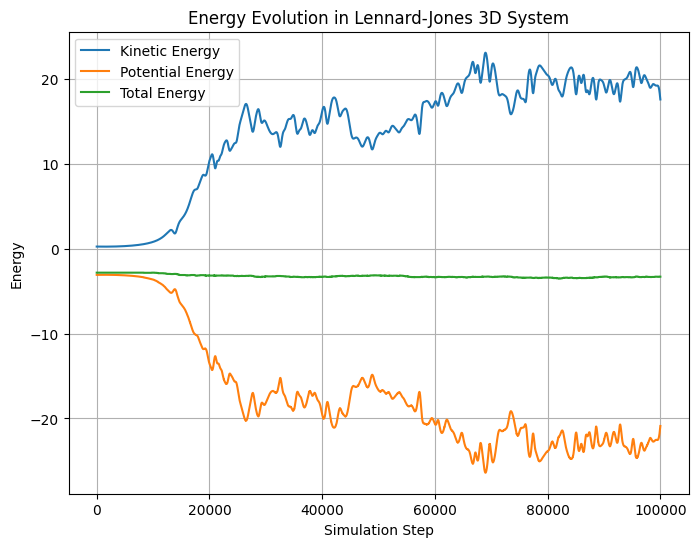

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Dentsity > 0.8 - test

# Parameterdefinition
n_particles = 20
sigma = 1.0
epsilon = 1.0
cutoff = 2.5 * sigma
box_size = 6.0
dt = 0.0001
steps = 100000

class LennardJones3D:
    def __init__(self, n_particles, sigma, epsilon, cutoff, box_size, dt):
        self.n_particles = n_particles
        self.sigma = sigma
        self.epsilon = epsilon
        self.cutoff = cutoff
        self.box_size = box_size
        self.dt = dt
        
        self.positions = self._initialize_positions()
        self.velocities = np.random.normal(0, 0.1, size=(self.n_particles, 3))
        self.velocities -= np.mean(self.velocities, axis=0)  # Zero net momentum
        self.forces = np.zeros_like(self.positions)
        
        self._compute_forces()
    
    def _initialize_positions(self):
        """ Initialize positions in a cubic lattice """
        n_side = int(np.ceil(self.n_particles ** (1/3)))
        spacing = self.box_size / n_side
        positions = []
        for x in range(n_side):
            for y in range(n_side):
                for z in range(n_side):
                    if len(positions) < self.n_particles:
                        positions.append([(x + 0.5) * spacing, (y + 0.5) * spacing, (z + 0.5) * spacing])
        return np.array(positions)
    
    def _compute_forces(self):
        """ Compute Lennard-Jones forces and potential energy """
        self.forces.fill(0)
        self.potential_energy = 0.0
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                r_ij = self.positions[i] - self.positions[j]
                r_ij -= self.box_size * np.round(r_ij / self.box_size) 
                r2 = np.dot(r_ij, r_ij)
                
                if r2 < self.cutoff ** 2:
                    r2_inv = 1.0 / r2
                    r6_inv = r2_inv ** 3
                    r12_inv = r6_inv ** 2
                    force_mag = 24 * self.epsilon * (2 * r12_inv - r6_inv) * r2_inv
                    force_vec = force_mag * r_ij
                    
                    self.forces[i] += force_vec
                    self.forces[j] -= force_vec
                    self.potential_energy += 4 * self.epsilon * (r12_inv - r6_inv)
    
    def velocity_verlet_step(self):
        """ Perform one step of Velocity Verlet integration """
        accelerations = self.forces
        self.positions += self.velocities * self.dt + 0.5 * accelerations * self.dt ** 2
        self.positions %= self.box_size  # Periodic 
        old_forces = self.forces.copy()
        self._compute_forces()
        new_accelerations = self.forces
        self.velocities += 0.5 * (old_forces + new_accelerations) * self.dt
    
    def compute_kinetic_energy(self):
        """ Compute kinetic energy """
        return 0.5 * np.sum(self.velocities**2)
    
    def compute_total_energy(self):
        """ Compute total energy """
        return self.compute_kinetic_energy() + self.potential_energy
    
    def simulate(self, steps):
        """ Run the simulation for a given number of steps """
        positions_history = []
        kinetic_energy_history = []
        potential_energy_history = []
        total_energy_history = []
        
        for _ in range(steps):
            self.velocity_verlet_step()
            positions_history.append(self.positions.copy())
            kinetic_energy_history.append(self.compute_kinetic_energy())
            potential_energy_history.append(self.potential_energy)
            total_energy_history.append(self.compute_total_energy())
        
        return np.array(positions_history), kinetic_energy_history, potential_energy_history, total_energy_history

# Run simulation
lj3d = LennardJones3D(n_particles, sigma, epsilon, cutoff, box_size, dt)
history, kin_energy, pot_energy, tot_energy = lj3d.simulate(steps)

# Plot energy over time
plt.figure(figsize=(8, 6))
plt.plot(kin_energy, label='Kinetic Energy')
plt.plot(pot_energy, label='Potential Energy')
plt.plot(tot_energy, label='Total Energy')
plt.xlabel('Simulation Step')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()
plt.title('Energy Evolution in Lennard-Jones 3D System')
plt.show()


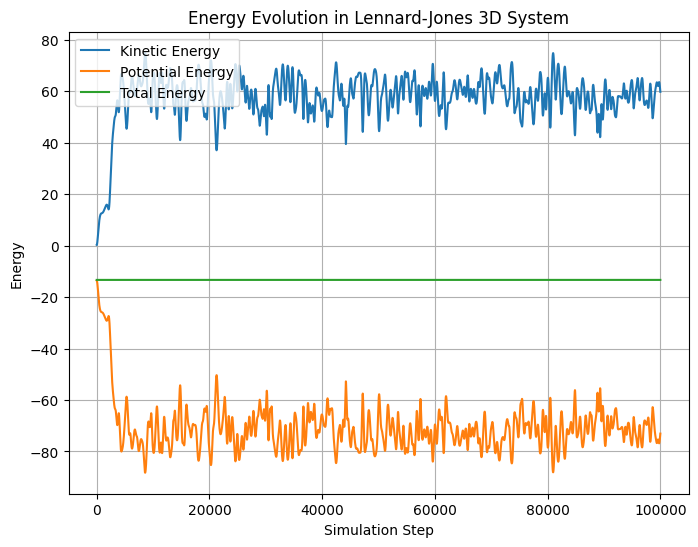

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameterdefinition
n_particles = 20
sigma = 1.0
epsilon = 1.0
cutoff = 2.5 * sigma
density = 0.8
box_size = (n_particles / density) ** (1/3)
dt = 0.0001
steps = 100000
damping = 0.93

class LennardJones3D:
    def __init__(self, n_particles, sigma, epsilon, cutoff, box_size, dt):
        self.n_particles = n_particles
        self.sigma = sigma
        self.epsilon = epsilon
        self.cutoff = cutoff
        self.box_size = box_size
        self.dt = dt
        
        self.positions = self._initialize_positions()
        self.velocities = np.random.normal(0, 0.1, size=(self.n_particles, 3))
        self.velocities -= np.mean(self.velocities, axis=0)  # Zero net momentum
        self.forces = np.zeros_like(self.positions)
        
        self._compute_forces()
    
    def _initialize_positions(self):
        """ Initialize positions in a cubic lattice """
        n_side = int(np.ceil(self.n_particles ** (1/3)))
        spacing = self.box_size / n_side
        positions = []
        for x in range(n_side):
            for y in range(n_side):
                for z in range(n_side):
                    if len(positions) < self.n_particles:
                        positions.append([(x + 0.5) * spacing, (y + 0.5) * spacing, (z + 0.5) * spacing])
        return np.array(positions)
    
    def _compute_forces(self):
        """ Compute Lennard-Jones forces and potential energy """
        self.forces.fill(0)
        self.potential_energy = 0.0
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                r_ij = self.positions[i] - self.positions[j]
                r_ij -= self.box_size * np.round(r_ij / self.box_size) 
                r2 = np.dot(r_ij, r_ij)
                
                if r2 < self.cutoff ** 2:
                    r2_inv = 1.0 / r2
                    r6_inv = r2_inv ** 3
                    r12_inv = r6_inv ** 2
                    force_mag = 24 * self.epsilon * (2 * r12_inv - r6_inv) * r2_inv
                    force_vec = force_mag * r_ij
                    
                    self.forces[i] += force_vec
                    self.forces[j] -= force_vec
                    self.potential_energy += 4 * self.epsilon * (r12_inv - r6_inv)
    
    def velocity_verlet_step(self):
        """ Perform one step of Velocity Verlet integration """
        accelerations = self.forces
        self.positions += self.velocities * self.dt + 0.5 * accelerations * self.dt ** 2
        self.positions %= self.box_size  # Periodic 
        old_forces = self.forces.copy()
        self._compute_forces()
        new_accelerations = self.forces
        self.velocities += 0.5 * (old_forces + new_accelerations) * self.dt
    
    def compute_kinetic_energy(self):
        """ Compute kinetic energy """
        return 0.5 * np.sum(self.velocities**2)
    
    def compute_total_energy(self):
        """ Compute total energy """
        return self.compute_kinetic_energy() + self.potential_energy
    
    def simulate(self, steps):
        """ Run the simulation for a given number of steps """
        positions_history = []
        kinetic_energy_history = []
        potential_energy_history = []
        total_energy_history = []
        
        for _ in range(steps):
            self.velocity_verlet_step()
            positions_history.append(self.positions.copy())
            kinetic_energy_history.append(self.compute_kinetic_energy())
            potential_energy_history.append(self.potential_energy)
            total_energy_history.append(self.compute_total_energy())
        
        return np.array(positions_history), kinetic_energy_history, potential_energy_history, total_energy_history

# Run simulation
lj3d = LennardJones3D(n_particles, sigma, epsilon, cutoff, box_size, dt)
history, kin_energy, pot_energy, tot_energy = lj3d.simulate(steps)

# Plot energy over time
plt.figure(figsize=(8, 6))
plt.plot(kin_energy, label='Kinetic Energy')
plt.plot(pot_energy, label='Potential Energy')
plt.plot(tot_energy, label='Total Energy')
plt.xlabel('Simulation Step')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()
plt.title('Energy Evolution in Lennard-Jones 3D System')
plt.show()


Energy minimization.

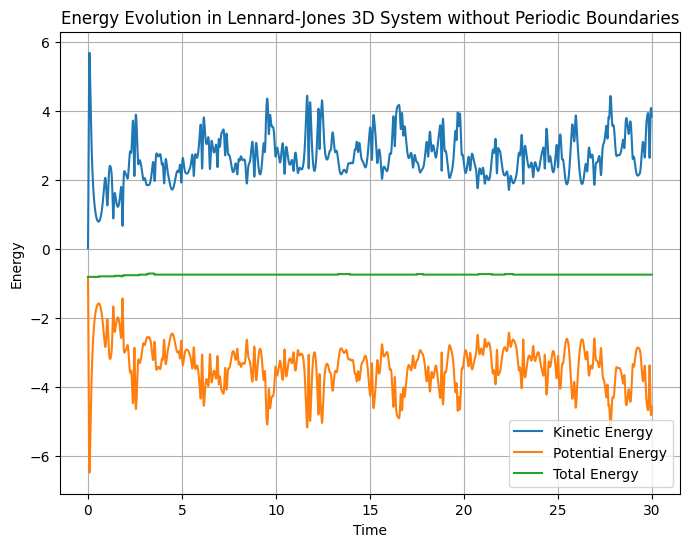

In [2]:
import numpy as np
import matplotlib.pyplot as plt

n_particles = 5
sigma = 1.0
epsilon = 1.0
cutoff = 2.5 * sigma
density = 0.8
box_size = (n_particles / density) ** (1/3)
dt = 0.0001
minimization_steps = 5000
simulation_steps = 300000

class LennardJones3D:
    def __init__(self, n_particles, sigma, epsilon, cutoff, box_size, dt):
        self.n_particles = n_particles
        self.sigma = sigma
        self.epsilon = epsilon
        self.cutoff = cutoff
        self.box_size = box_size
        self.dt = dt
        
        self.positions = self._initialize_positions()
        self.velocities = np.random.normal(0, 0.1, size=(self.n_particles, 3))
        self.velocities -= np.mean(self.velocities, axis=0)  # Zero net momentum
        self.forces = np.zeros_like(self.positions)
        
        self._compute_forces()
    
    def _initialize_positions(self):
        """ Initialize positions in a cubic lattice """
        n_side = int(np.ceil(self.n_particles ** (1/3)))
        spacing = self.box_size / n_side
        positions = []
        for x in range(n_side):
            for y in range(n_side):
                for z in range(n_side):
                    if len(positions) < self.n_particles:
                        positions.append([(x + 0.5) * spacing, (y + 0.5) * spacing, (z + 0.5) * spacing])
        return np.array(positions)
    
    def _compute_forces(self):
        """ Compute Lennard-Jones forces and potential energy """
        self.forces.fill(0)
        self.potential_energy = 0.0
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                r_ij = self.positions[i] - self.positions[j
                r2 = np.dot(r_ij, r_ij) 
                
                if r2 < self.cutoff ** 2:
                    r2_inv = 1.0 / r2
                    r6_inv = r2_inv ** 3
                    r12_inv = r6_inv ** 2
                    force_mag = 24 * self.epsilon * (2 * r12_inv - r6_inv) * r2_inv
                    force_vec = force_mag * r_ij
                    
                    self.forces[i] += force_vec
                    self.forces[j] -= force_vec
                    
                    self.potential_energy += 4 * self.epsilon * (r12_inv - r6_inv)
    
    def velocity_verlet_step(self):
        """ Perform one step of Velocity Verlet integration """
        accelerations = self.forces
        self.positions += self.velocities * self.dt + 0.5 * accelerations * self.dt ** 2
        old_forces = self.forces.copy()
        self._compute_forces()
        new_accelerations = self.forces
        self.velocities += 0.5 * (old_forces + new_accelerations) * self.dt
    
    def compute_kinetic_energy(self):
        """ Compute kinetic energy """
        return 0.5 * np.sum(self.velocities**2)
    
    def compute_total_energy(self):
        """ Compute total energy """
        return self.compute_kinetic_energy() + self.potential_energy
    
    def minimize_energy(self, steps):
        """ Perform energy minimization using a simple steepest descent method """
        for _ in range(steps):
            self.velocity_verlet_step()
            self.velocities *= 0.93  
            #self.velocities = np.zeros_like(self.velocities)
    
    def simulate(self, steps):
        """ Run the simulation for a given number of steps """
        positions_history = []
        kinetic_energy_history = []
        potential_energy_history = []
        total_energy_history = []
        
        times = np.arange(0, steps * self.dt, self.dt)
        
        for _ in range(steps):
            self.velocity_verlet_step()
            positions_history.append(self.positions.copy())
            kinetic_energy_history.append(self.compute_kinetic_energy())
            potential_energy_history.append(self.potential_energy)
            total_energy_history.append(self.compute_total_energy())
        
        return np.array(positions_history), times, kinetic_energy_history, potential_energy_history, total_energy_history


lj3d = LennardJones3D(n_particles, sigma, epsilon, cutoff, box_size, dt)
lj3d.minimize_energy(minimization_steps)
history, times, kin_energy, pot_energy, tot_energy = lj3d.simulate(simulation_steps)

plt.figure(figsize=(8, 6))
plt.plot(times, kin_energy, label='Kinetic Energy')
plt.plot(times, pot_energy, label='Potential Energy')
plt.plot(times, tot_energy, label='Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.grid('True')
plt.legend()
plt.title('Energy Evolution in Lennard-Jones 3D System without Periodic Boundaries')
plt.show()


Computational time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define all fixed parameters
sigma = 1.0
epsilon = 1.0
cutoff = 2.5 * sigma
density = 0.8
dt = 0.0001
minimization_steps = 5000
simulation_steps = 100
damping = 0.9

class LennardJones3D:
    def __init__(self, n_particles, sigma, epsilon, cutoff, box_size, dt):
        self.n_particles = n_particles
        self.sigma = sigma
        self.epsilon = epsilon
        self.cutoff = cutoff
        self.box_size = box_size
        self.dt = dt
        
        self.positions = self._initialize_positions()
        self.velocities = np.random.normal(0, 0.1, size=(self.n_particles, 3))
        self.velocities -= np.mean(self.velocities, axis=0) 
        self.forces = np.zeros_like(self.positions)
        
        self._compute_forces()
    
    def _initialize_positions(self):
        """ Initialize positions in a cubic lattice """
        n_side = int(np.ceil(self.n_particles ** (1/3)))
        spacing = self.box_size / n_side
        positions = []
        for x in range(n_side):
            for y in range(n_side):
                for z in range(n_side):
                    if len(positions) < self.n_particles:
                        positions.append([(x + 0.5) * spacing, (y + 0.5) * spacing, (z + 0.5) * spacing])
        return np.array(positions)
    
    def _compute_forces(self):
        """ Compute Lennard-Jones forces and potential energy """
        self.forces.fill(0)
        self.potential_energy = 0.0
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                r_ij = self.positions[i] - self.positions[j]
                r2 = np.dot(r_ij, r_ij)  
                
                if r2 < self.cutoff ** 2:
                    r2_inv = 1.0 / r2
                    r6_inv = r2_inv ** 3
                    r12_inv = r6_inv ** 2
                    force_mag = 24 * self.epsilon * (2 * r12_inv - r6_inv) * r2_inv
                    force_vec = force_mag * r_ij
                    
                    self.forces[i] += force_vec
                    self.forces[j] -= force_vec
                    
                    self.potential_energy += 4 * self.epsilon * (r12_inv - r6_inv)
    
    def velocity_verlet_step(self):
        """ Perform one step of Velocity Verlet integration """
        accelerations = self.forces
        self.positions += self.velocities * self.dt + 0.5 * accelerations * self.dt ** 2
        old_forces = self.forces.copy()
        self._compute_forces()
        new_accelerations = self.forces
        self.velocities += 0.5 * (old_forces + new_accelerations) * self.dt
    
    def minimize_energy(self, steps):
        """ Perform energy minimization using a simple steepest descent method """
        for _ in range(steps):
            self.velocity_verlet_step()
            self.velocities *= damping 
    
    def simulate(self, steps):
        """ Run the simulation for a given number of steps """
        for _ in range(steps):
            self.velocity_verlet_step()

particle_counts = [5, 10, 15, 20, 50, 100]
runtimes = []

for n_particles in particle_counts:
    box_size = (n_particles / density) ** (1/3)
    lj3d = LennardJones3D(n_particles, sigma, epsilon, cutoff, box_size, dt)
    lj3d.minimize_energy(minimization_steps)
    
    start_time = time.time()
    lj3d.simulate(simulation_steps)
    end_time = time.time()
    
    runtime = end_time - start_time
    runtimes.append(runtime)
    print(f"N = {n_particles}, Time = {runtime:.4f} sec")

# Plot computation time vs. system size
plt.figure(figsize=(8, 6))
plt.plot(particle_counts, runtimes, marker='o', linestyle='-')
plt.xlabel('Number of Particles')
plt.ylabel('Computation Time (seconds)')
plt.title('Scaling of Computation Time with System Size')
plt.grid()
plt.show()


N = 5, Time = 0.0057 sec
N = 10, Time = 0.0182 sec
N = 15, Time = 0.0427 sec
N = 20, Time = 0.0734 sec
N = 50, Time = 0.3686 sec
